# Saving Money from Predicting Los Angeles Gas Price

### Table of Contents
* Set-up
* Correlation between National and Local Gas Price Move Direction
* Logistic Regression Model for Local Price Move
  * Features
  * Logistic Regression Path
  * l2 Regularization Parameter
* Test in Cross-Validation Period
  + Prediction
  + Recall
  + Accuracy
* How Much Money Can I Save?
  + Is it even possible to do much better?

## Set-up

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import logistic_regression_path, LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.svm import l1_min_c
%matplotlib inline

/Users/ChingYunH/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def custom_read_csv(filename):
    df = pd.read_csv(filename)
    df['date'] = pd.to_datetime(df['date'])
    return df.set_index('date')

Read retail gas prices from csv.

In [3]:
# note that all prices are released on Monday, dayofweek = 0
national_price = custom_read_csv('national.csv').dropna()
state_price = custom_read_csv('state.csv')
state_price = state_price.drop('Unnamed: 10', axis=1).dropna()
city_price = custom_read_csv('city.csv').dropna()
price = pd.concat([national_price, state_price, city_price], axis=1)

The training period is 2003 - 2010. (Local price data are only available after 2003.)

Save 2011 - 2016 for cross-validation.

In [4]:
trainingdates = np.intersect1d(price.index, pd.date_range('2003-06-02','2010-12-31'))

## Correlation between National and Local Gas Price Move Direction

In [5]:
up = (price - price.shift(1)).dropna() > 0

In [6]:
pd.Series(index=up.columns, data=np.corrcoef(up, rowvar=False)[0], name='correlation').sort_values(ascending=False)

national     1.000000
tx           0.811964
houston      0.734241
fl           0.702703
miami        0.683383
ma           0.682867
boston       0.672109
chicago      0.650741
nyc          0.634477
ny           0.615660
co           0.613564
mn           0.580886
denver       0.575400
la           0.573159
ca           0.570531
wa           0.567862
cleveland    0.539205
oh           0.536356
seattle      0.530120
sf           0.528574
Name: correlation, dtype: float64

Local gas price moves could be very different from national gas price, such as in SF or in LA. 

Since I'm near Los Angeles, I'll study Los Angeles and the California state as a detailed example.

In [7]:
correls = up.rolling(window=52*2).corr().dropna().unstack()

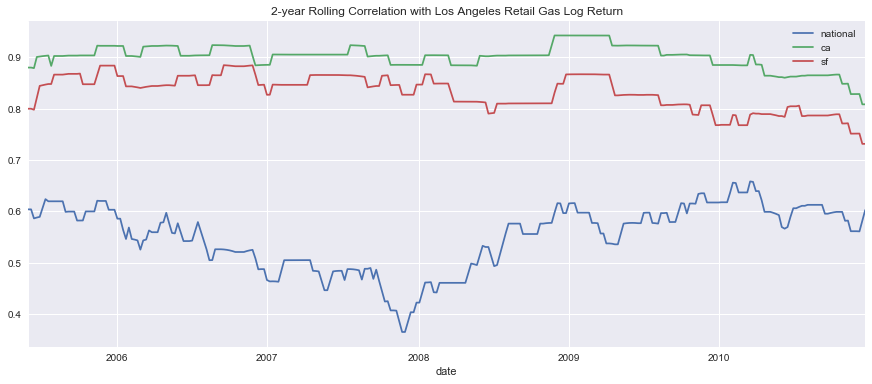

In [8]:
correls['la'][['national', 'ca', 'sf']].loc[trainingdates[52*2:]].plot(
    figsize=(15,6), title='2-year Rolling Correlation with Los Angeles Retail Gas Log Return')
plt.show()

The local retail gas price in LA is highly correlated to price in San Francisco and the state price in California, but not as much with national price.

## Logistic Regression Model for Local Price Move

Therefore, it's better to fit a new logistic regression model to LA local price move, rather than reusing the national model. 

The modeling procedure is similar to the national model.

### Features

We use the same features as in the national model. The features are **log returns** of the following time series:

* Gulf Coast gasoline spot price
* Gasoline stocks
* Retail gas price lagged by 1,2,3 weeks

All features are weekly time series.

In [9]:
gasspot = custom_read_csv('gasspot.csv').drop('Unnamed: 3', axis=1).dropna()
stocks = custom_read_csv('stocks.csv').dropna()
predictors_raw = pd.concat([gasspot.gas_spot_gulf, stocks.stocks_gasoline], axis=1)

# the predictors are relaesed on Friday, add 3 days to align
predictors_raw.index = predictors_raw.index + pd.DateOffset(days=3)

# include the lagged series by 1,2,3 weeks to capture autocorrelation
predictors_raw = pd.concat([predictors_raw] + \
                           [price.national.shift(i).rename('retail gas lag %d week'%i) for i in range(1,4)], 
                           axis=1)

# take log return for all predictors
predictors = (predictors_raw - predictors_raw.shift(1)) / predictors_raw.shift(1)

### Logistic Regression Path

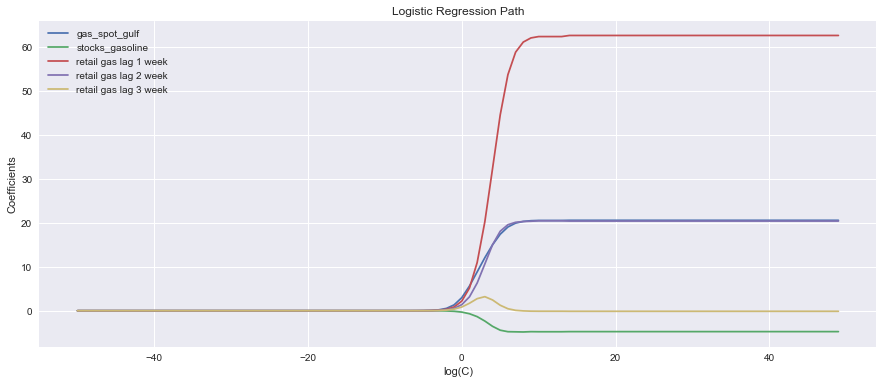

In [10]:
y1 = up['la'].loc[trainingdates].values
X1 = predictors.loc[trainingdates].values
cs = np.exp(np.arange(-50,50,1))
coefs, Cs, _ = logistic_regression_path(X1, y1, Cs=cs)

plt.figure(figsize=(15,6))
plt.plot(np.log(Cs), [x[:-1] for x in coefs])
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.legend(predictors.columns)
plt.show()

###  l2 Regularization Parameter

Search for the best l2 regularization coefficient.

Devide the training set into two halves randomly. 

For each candidate regularization parameter, 
* fit logistic regression model to the first half of training set
* record the prediction accuracy on the second half of the training set 

Pick the regularization parameter with highest accuracy.

In [11]:
training1 = trainingdates[np.random.permutation(len(trainingdates))[:len(trainingdates)/2]]
training2 = trainingdates[np.random.permutation(len(trainingdates))[len(trainingdates)/2:]]

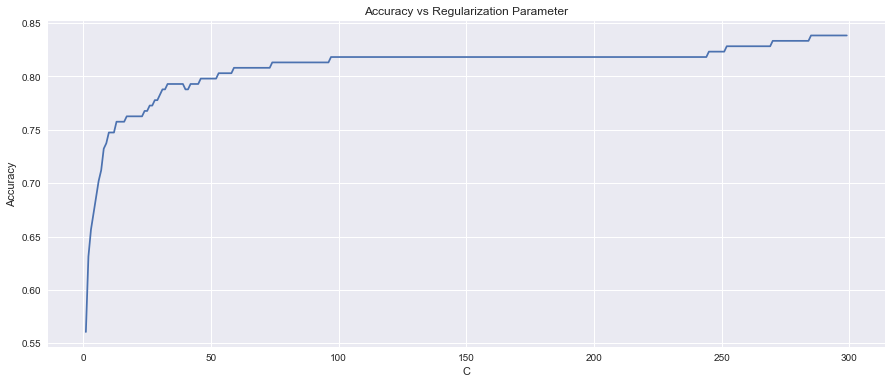

Regularization parameter with highest accuracy: 285


In [12]:
y1 = up['la'].loc[training1].values
X1 = predictors.loc[training1].values
y2 = up['la'].loc[training2].values
X2 = predictors.loc[training2].values

Cs = np.arange(1,300)
score = np.zeros(len(Cs))
for i, C in enumerate(Cs):
    model = LogisticRegression(C=C).fit(X1, y1)
    score[i] = model.score(X2, y2)
    
plt.figure(figsize=(15,6))
plt.plot(Cs, score)
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Regularization Parameter')
plt.show()

print 'Regularization parameter with highest accuracy: %.0f' % Cs[np.argmax(score)]

According to the above result, choose **93** as the regularization parameter for logistics regression

## Test in Cross-Validation Period

### Metric: Precision and Recall of Predicted Price Move Directions

In [13]:
cvdates = np.intersect1d(price.index, pd.date_range('2011-01-01','2016-12-31'))

In [14]:
y_training = up['la'].loc[trainingdates].values
X_training = predictors.loc[trainingdates].values
model = LogisticRegression(C=81).fit(X_training, y_training)

y_cv = up['la'].loc[cvdates].values
X_cv = predictors.loc[cvdates].values
prediction = model.predict(X_cv)

#### Precision

In [15]:
1.0 * np.logical_and(y_cv, prediction).sum() / prediction.sum()

0.7745098039215687

#### Recall

In [16]:
1.0 * np.logical_and(y_cv, prediction).sum() / y_cv.sum()

0.5939849624060151

#### Accuracy

In [17]:
1.0 * (y_cv == prediction).sum() / len(prediction)

0.7539936102236422

## How much money can I save?

The average fuel consumpersion per car per year in the US is roughly estimated to be 300 - 400 gallons, so that's about 6 gallons per week. 

My family's Honda Odyssey holds about 20 gallons. Let's say it's 18 gallons, and consider the bottom 2 gallons as emergency gas.

Consider the following scenario: 

Suppose I have 8 gallons left in the tank (enough for another week), and I know the price will go up/down next week.
* If the gas price goes up, I should fill the tank now.
* If the gas price goes down, I should wait until next week.

With this strategy, a good prediction of price move direction can save me some money. (The baseline comparison is filling the tank once every 3 weeks.)

Let's see how much money I can theoretically save in 2011 - 2016 (the cross validation period).

In [18]:
# Baseline comparison:
cost = price.la[cvdates[np.arange(len(cvdates)) % 3 == 0]].sum() * (6 * 3)
cost

6851.988

In [19]:
# Filling gas tank based on prediction:
remaining = 0
cost = 0
weekly_gas = 6
tank_size = 18

y_training = up['la'].loc[trainingdates].values
X_training = predictors.loc[trainingdates].values
model = LogisticRegression(C=81).fit(X_training, y_training)
X_cv = predictors.loc[cvdates].values
prediction = pd.Series(index=cvdates, data=model.predict(X_cv))

for i,date in enumerate(cvdates):
    if i != len(cvdates)-1 and prediction.loc[cvdates[i+1]]:
        add = tank_size - remaining
    else:
        add = max(0, weekly_gas - remaining)
    remaining += add
    cost += add * price.la[date]
    
    remaining -= weekly_gas
    
    assert remaining >= 0
    assert remaining <= tank_size

In [20]:
cost, remaining

(6770.6339999999973, 6)

Naive strategy:
* Fill the tank once every 3 weeks.

With naive strategy, I spend about $6852 on gas in 2011-2016. At the end I have 12 gallons left in the tank.

Smarter strategy:
* If the price will go up, fill the full tank
* If the price will go down, only fill to have the minimum amount for another week

With smarter strategy, I spend $6770 in 2011-2016, and have 6 gallons at the end.

After accounting for the 6-gallon difference at the end, I save
$$($6852 - 6 * $2.77) - $6770 \approx $65$$

Hmm.. That's only 1% of the gas expenditure, perhaps not worth 6 years' planning.

### Is it even possible to do much better?

Theoretically, suppose I am a prophet and I somehow know the actual price move. Would I be able to save much more?

In [21]:
# Filling gas tank based on future price information (cheating!):
remaining = 0
cost = 0
weekly_gas = 6
tank_size = 18

y_training = up['la'].loc[trainingdates].values
X_training = predictors.loc[trainingdates].values
model = LogisticRegression(C=81).fit(X_training, y_training)
X_cv = predictors.loc[cvdates].values
prediction = pd.Series(index=cvdates, data=model.predict(X_cv))

for i,date in enumerate(cvdates):
    if i != len(cvdates)-1 and up.la.loc[cvdates[i+1]]:
        add = tank_size - remaining
    else:
        add = max(0, weekly_gas - remaining)
    remaining += add
    cost += add * price.la[date]
    
    remaining -= weekly_gas
    
    assert remaining >= 0
    assert remaining <= tank_size

In [22]:
cost, remaining

(6716.3999999999987, 6)

Even if I know the future price, I would only be able save \$54 more. 

**This means no matter how good my prediction is, I would save at most \$65 + \$54 = \$119 in 6 years.**

Moral of the story? Perhaps I should have found this out first before doing all the prediction models.